# Glaucoma Segmentation


## Imports

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from networks import *
from training import *
from utils import *

## Setup

In [2]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
LOGS_DIR = '../logs/'
CHECKPOINT_DIR = '../checkpoints/'
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
IN_CHANNELS = 3
OUT_CHANNELS = 3
NETWORK_NAME = 'unet'
LOSS_FUNCTION = 'dice'
OPTIMIZER = 'adam'
ARCHITECTURE = 'multiclass'  # multiclass, binary, dual, cascade
SCHEDULER = 'plateau'
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 3
LAYERS = [32, 64, 128, 256, 512]
EARLY_STOPPING_PATIENCE = 10
LOG_INTERVAL = 5
SAVE_INTERVAL = 10
NUM_WORKERS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PIN_MEMORY = True if DEVICE == 'cuda' else False
USE_WANDB = False
DEEP_SUPERVISION = False

os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f'''CONFIGURATION:
    PyTorch version: {torch.__version__}
    Using device: {DEVICE}
    Network: {NETWORK_NAME}
    Architecture: {ARCHITECTURE}
    Optimizer: {OPTIMIZER}
    Loss function: {LOSS_FUNCTION}
    Scheduler: {SCHEDULER}
    Image directory: {IMAGE_DIR}
    Mask directory: {MASK_DIR}
    Input image height & width: {IMAGE_HEIGHT}x{IMAGE_WIDTH}
    Number of input channels: {IN_CHANNELS}
    Number of output channels: {OUT_CHANNELS}
    Layers: {LAYERS}
    Batch size: {BATCH_SIZE}
    Learning rate: {LEARNING_RATE}
    Epochs: {EPOCHS}
    Early stopping patience: {EARLY_STOPPING_PATIENCE}
    Save interval: {SAVE_INTERVAL}
    Log interval: {LOG_INTERVAL}
    Number of workers: {NUM_WORKERS}
    Pin memory: {PIN_MEMORY}
    Weight & Biases: {USE_WANDB}
    Deep supervision: {DEEP_SUPERVISION}''')

CONFIGURATION:
    PyTorch version: 2.0.1+cu118
    Using device: cuda
    Network: unet
    Architecture: multiclass
    Optimizer: adam
    Loss function: dice
    Scheduler: plateau
    Image directory: ../data/ORIGA/Images_Cropped
    Mask directory: ../data/ORIGA/Masks_Cropped
    Input image height & width: 128x128
    Number of input channels: 3
    Number of output channels: 3
    Layers: [32, 64, 128, 256, 512]
    Batch size: 4
    Learning rate: 0.0001
    Epochs: 3
    Early stopping patience: 10
    Save interval: 10
    Log interval: 5
    Number of workers: 4
    Pin memory: True
    Weight & Biases: False
    Deep supervision: False


## Dataset

In [3]:
def polar_transform(img, **kwargs):
    height, width = img.shape[:2]
    center = (width // 2, height // 2)
    value = np.sqrt(((width / 2.0) ** 2.0) + ((height / 2.0) ** 2.0))
    polar_img = cv.linearPolar(img, center, value, cv.WARP_FILL_OUTLIERS)
    polar_img = cv.rotate(polar_img, cv.ROTATE_90_COUNTERCLOCKWISE)
    return polar_img


def inverse_polar_transform(img, **kwargs):
    img = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
    height, width = img.shape[:2]
    center = (width // 2, height // 2)
    value = np.sqrt(((width / 2.0) ** 2.0) + ((height / 2.0) ** 2.0))
    cartesian_img = cv.linearPolar(img, center, value, cv.WARP_INVERSE_MAP | cv.WARP_FILL_OUTLIERS)
    return cartesian_img


def arctan(x):
    return 1e-7 + (1 - 2 * 1e-7) * (0.5 + torch.arctan(x) / torch.tensor(np.pi))


Image shape: torch.Size([1, 3, 128, 128])
Mask shape: torch.Size([1, 128, 128])
Unique values and their counts in mask: {0: 5922, 1: 5486, 2: 4976}


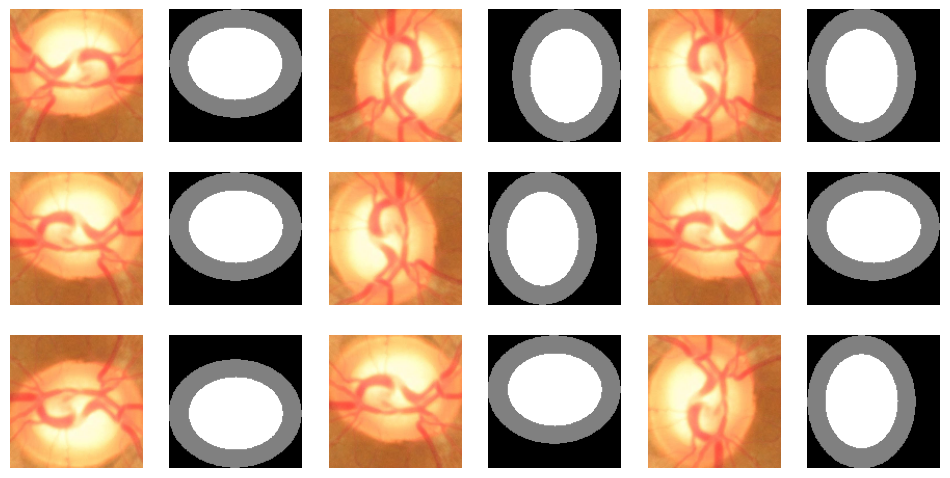

In [4]:
example_ds = OrigaDataset(IMAGE_DIR, MASK_DIR, os.listdir(IMAGE_DIR)[:1], A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),  # rotate by 0, 90, 180, or 270 degrees
    # A.Rotate(limit=30, p=0.33, border_mode=cv.BORDER_CONSTANT),
    # A.Lambda(image=polar_transform, mask=polar_transform),
    # A.Lambda(image=inverse_polar_transform, mask=inverse_polar_transform),
    # A.Sharpen(p=0.5, alpha=(0.1, 0.3), lightness=(0.5, 1.0)),

    # A.CLAHE(p=0.5),
    # A.RandomBrightnessContrast(p=0.5),
    # A.GridDistortion(p=0.5, border_mode=cv.BORDER_CONSTANT),
    # A.MedianBlur(p=0.5),
    # A.RandomToneCurve(p=0.5),
    # A.MultiplicativeNoise(p=0.5),

    ToTensorV2(),
]))
example_loader = DataLoader(example_ds, batch_size=1, shuffle=True)

example_image, example_mask = next(iter(example_loader))
print(f'Image shape: {example_image.shape}')
print(f'Mask shape: {example_mask.shape}')

unique, counts = np.unique(example_mask, return_counts=True)
print(f'Unique values and their counts in mask: {dict(zip(unique, counts))}')

# Plot example augmented images and masks
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.ravel()
for i in range(0, 3 * 6, 2):
    batch = next(iter(example_loader))
    images, masks = batch
    image, mask = images[0], masks[0]
    image = image.permute(1, 2, 0).numpy()
    mask = mask.numpy()
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i + 1].imshow(mask, cmap='gray')
    ax[i + 1].axis('off')
plt.show()

In [5]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ToTensorV2(),
])

train_loader, val_loader, test_loader = load_origa(
    IMAGE_DIR, MASK_DIR, 0.7, 0.15, 0.15,
    train_transform, val_transform, val_transform, BATCH_SIZE, PIN_MEMORY, NUM_WORKERS
)


Loading ORIGA dataset:
    Train size: 454 (69.85%)
    Validation size: 98 (15.08%)
    Test size: 98 (15.08%)
    
    Image shape: (3, 128, 128)
    Mask shape: (128, 128)
    Batch size: 4

    Train loader length: 114
    Validation loader length: 25
    Test loader length: 25


## Model

In [6]:
model = get_network(NETWORK_NAME, in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, layers=LAYERS).to(DEVICE)
optimizer = get_optimizer(OPTIMIZER, model.parameters(), lr=LEARNING_RATE)
criterion = get_criterion(LOSS_FUNCTION, num_classes=OUT_CHANNELS)
scheduler = get_scheduler(SCHEDULER, optimizer, factor=0.1, patience=5, verbose=True)
scaler = None
# scaler = torch.cuda.amp.GradScaler()

init_weights(model)

Initialized Unet network parameters with kaiming method.


## Training

In [ ]:
if ARCHITECTURE == 'multiclass':
    hist = train_multiclass(
        model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
    )

if ARCHITECTURE == 'binary':
    hist = train_binary(
        model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
    )

if ARCHITECTURE == 'dual':
    hist = train_dual(
        model, criterion, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
    )

if ARCHITECTURE == 'cascade':
    binary_model = Unet(3, 1, LAYERS).to(DEVICE)
    checkpoint = torch.load(CHECKPOINT_DIR + 'binary-model.pth')
    binary_model.load_state_dict(checkpoint)
    hist = train_cascade(
        binary_model, model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
    )


In [ ]:
# Plot metrics
used_metrics = sorted([m[6:] for m in hist.keys() if m.startswith('train_')])
fig, ax = plt.subplots(4, 4, figsize=(14, 8))
ax = ax.ravel()

for i, metric in enumerate(used_metrics):
    ax[i].plot(hist[f'train_{metric}'], label=f'train')
    ax[i].plot(hist[f'val_{metric}'], label=f'val')
    ax[i].set_title(metric[0].upper() + metric[1:].replace('_', ' '))
    if metric != 'loss':
        ax[i].set_ylim(top=1)
    ax[i].legend()

for ax in ax[len(used_metrics):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Testing

In [ ]:
if ARCHITECTURE == 'multiclass':
    results = evaluate('multiclass', model, test_loader, criterion, DEVICE)

if ARCHITECTURE == 'binary':
    results = evaluate('binary', model, test_loader, criterion, DEVICE)

if ARCHITECTURE == 'dual':
    results = evaluate('dual', model, test_loader, criterion, DEVICE)

if ARCHITECTURE == 'cascade':
    binary_model = Unet(3, 1, LAYERS).to(DEVICE)
    checkpoint = torch.load(CHECKPOINT_DIR + 'binary-model.pth')
    binary_model.load_state_dict(checkpoint)
    results = evaluate('cascade', model, test_loader, criterion, DEVICE, model0=binary_model)

In [ ]:
if ARCHITECTURE == 'multiclass':
    plot_results_from_loader('multiclass', test_loader, model, DEVICE, n_samples=4,
                             save_path=f'{LOGS_DIR}/evaluation.png')

if ARCHITECTURE == 'binary':
    plot_results_from_loader('binary', test_loader, model, DEVICE, n_samples=4,
                             save_path=f'{LOGS_DIR}/evaluation.png')

if ARCHITECTURE == 'dual':
    plot_results_from_loader('dual', test_loader, model, DEVICE,
                             n_samples=4, save_path=f'{LOGS_DIR}/evaluation.png')

if ARCHITECTURE == 'cascade':
    plot_results_from_loader('cascade', test_loader, model, DEVICE, n_samples=4,
                             save_path=f'{LOGS_DIR}/evaluation.png', model0=binary_model)

## Work in progress

In [7]:
# torch.save(model.state_dict(), CHECKPOINT_DIR + 'model.pth')

checkpoint = torch.load(CHECKPOINT_DIR + 'multiclass-model.pth')
model = Unet(3, 3, LAYERS).to(DEVICE)
# model = DualUnet(3, 1, LAYERS).to(DEVICE)
criterion = DiceLoss(3)
model.load_state_dict(checkpoint)

# binary_model = Unet(3, 1, LAYERS).to(DEVICE)
# checkpoint = torch.load(CHECKPOINT_DIR + 'binary-model.pth')
# binary_model.load_state_dict(checkpoint)

<All keys matched successfully>

Batch 12 metrics: {'accuracy_OD': 0.968170166015625, 'precision_OD': 0.9747278946822846, 'sensitivity_OD': 0.9818933650773761, 'specificity_OD': 0.9309465813176231, 'dice_OD': 0.9782975093114713, 'iou_OD': 0.9575170054172946, 'accuracy_OC': 0.90179443359375, 'precision_OC': 0.8851229415745545, 'sensitivity_OC': 0.7810789290335424, 'specificity_OC': 0.9551736279213063, 'dice_OC': 0.8298524824194998, 'iou_OC': 0.7091862093895441}


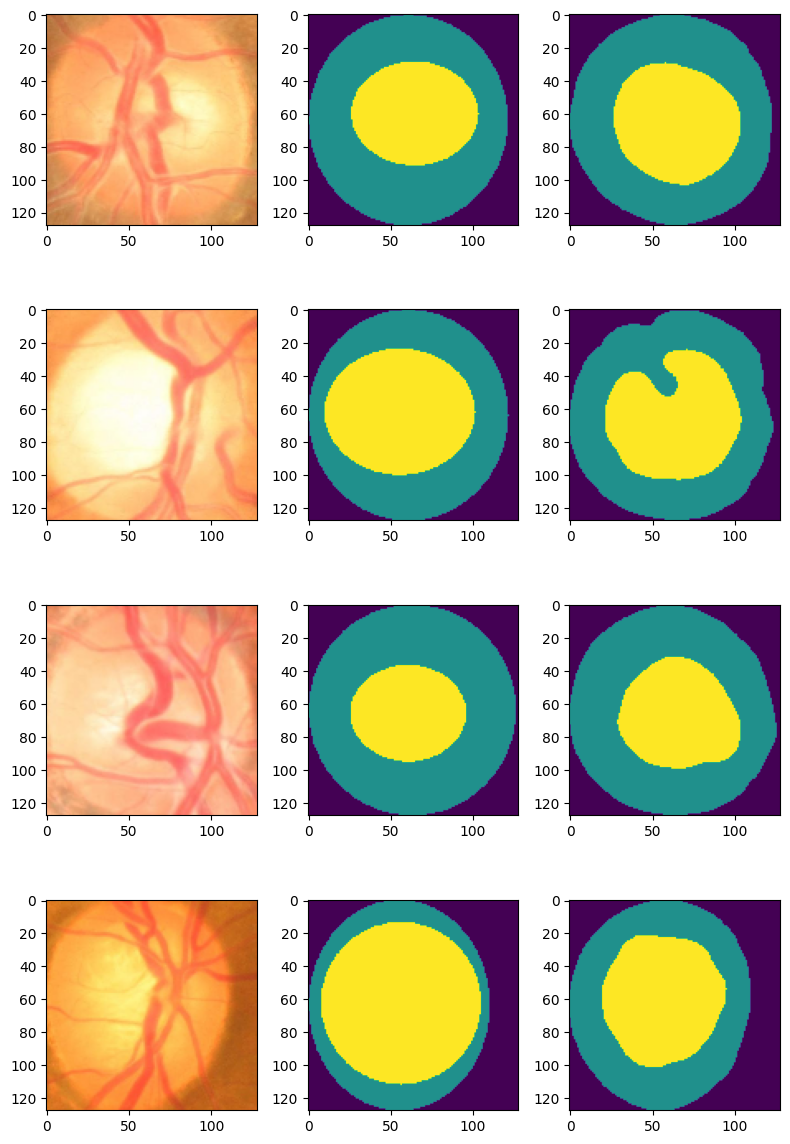

In [14]:
# Non-ellipse: 5, 12
# Holes: 0, 20

target_batch = 12

for batch_idx, (images, masks) in enumerate(test_loader):
    if batch_idx != target_batch:
        continue
    images = images.float().to(DEVICE)
    masks = masks.long().to(DEVICE)

    outputs = model(images)
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)

    met = get_metrics(masks, preds, [[1, 2], [2]])

    images = images.detach().cpu().numpy().transpose(0, 2, 3, 1) / 255
    masks = masks.detach().cpu().numpy()
    preds = preds.detach().cpu().numpy()

    print(f'Batch {batch_idx} metrics: {met}')

    # Plot results
    fig, ax = plt.subplots(4, 3, figsize=(8, 12))
    ax = ax.ravel()
    for i in range(4):
        ax[3 * i].imshow(images[i])
        ax[3 * i + 1].imshow(masks[i])
        ax[3 * i + 2].imshow(preds[i])
    plt.tight_layout()
    plt.show()

    break

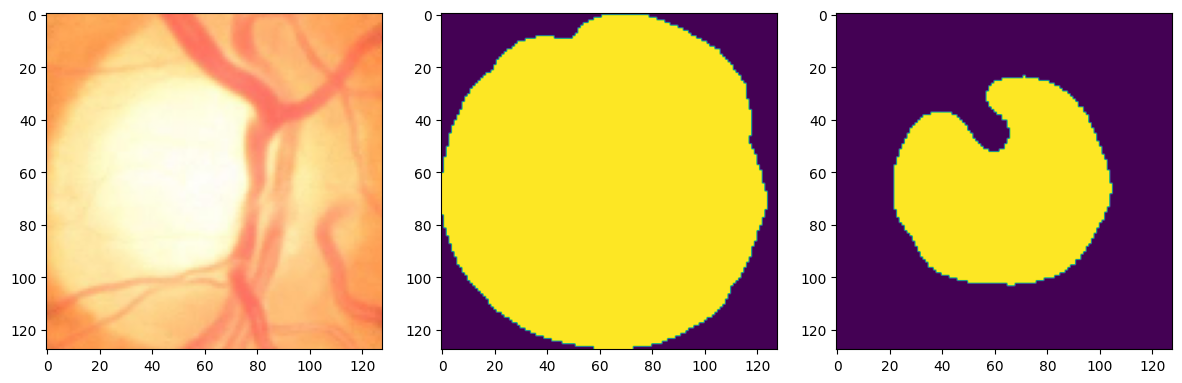

{'accuracy_OD': 0.89666748046875,
 'precision_OD': 0.8997272917977763,
 'sensitivity_OD': 0.7792514534883721,
 'specificity_OD': 0.9560661764705882,
 'dice_OD': 0.8351669749780937,
 'iou_OD': 0.716984286191909}

In [19]:
idx = 1

image = images[idx]
mask = masks[idx]
pred = preds[idx]

mask_od, mask_oc = separate_disc_and_cup_mask(mask)
pred_od, pred_oc = separate_disc_and_cup_mask(pred)

# plot image, OD mask and OC mask
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.ravel()
ax[0].imshow(image)
ax[1].imshow(pred_od)
ax[2].imshow(pred_oc)
plt.tight_layout()
plt.show()

get_metrics(mask_oc, pred_oc, [[1, 2]])

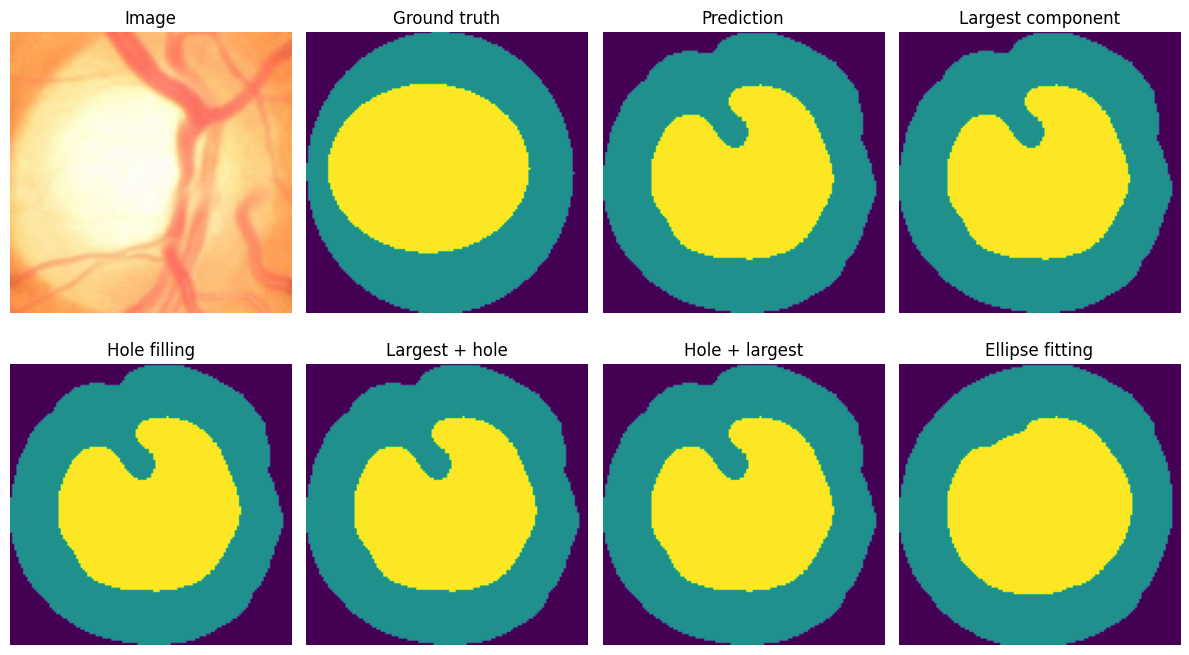

In [16]:
mask1 = apply_largest_component_selection(pred)
mask2 = apply_hole_filling(pred)
mask3 = apply_largest_component_selection(apply_hole_filling(pred))
mask4 = apply_hole_filling(apply_largest_component_selection(pred))
mask5 = apply_ellipse_fitting(pred)

# Plot results
_, ax = plt.subplots(2, 4, figsize=(12, 7))
ax = ax.ravel()
for a in ax:
    a.axis('off')

ax[0].set_title('Image')
ax[0].imshow(image)
ax[1].set_title('Ground truth')
ax[1].imshow(mask)
ax[2].set_title('Prediction')
ax[2].imshow(pred)
ax[3].set_title('Largest component')
ax[3].imshow(mask1)
ax[4].set_title('Hole filling')
ax[4].imshow(mask2)
ax[5].set_title('Largest + hole')
ax[5].imshow(mask3)
ax[6].set_title('Hole + largest')
ax[6].imshow(mask4)
ax[7].set_title('Ellipse fitting')
ax[7].imshow(mask5)

plt.tight_layout()
plt.show()

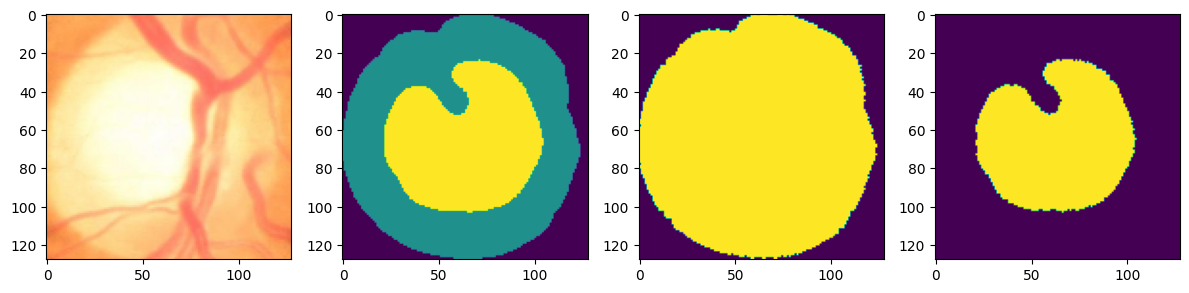

0.8458933926671182
0.8460570875665215
0.8457817337461301
0.8463846675055657
0.8450813323005422
0.8452830188679246
0.8454167069983545
0.8455284552845529
0.8455284552845529
0.8455284552845529
0.8457740342724368
0.8460495739736639
0.8457962030220845
0.8458781362007168
0.8457962030220845
0.8457962030220845
0.8457142857142858
0.8454386984311447
0.8454386984311447
0.8455504986927471
0.8456622773044152
0.8456921587608907
0.8455284552845529
0.84502952279547
0.84502952279547
0.8448359306940277
0.8448359306940277
0.8448359306940277
0.8447241045498548
0.8447241045498548
0.8447241045498548
0.8448058863394327
0.8448058863394327
0.8446940356312935
0.8448058863394327
0.8449694974339111
0.8450513267480148
0.8450513267480148
0.8452749806351665
0.8453568316064685
0.8456921587608907
0.8458559256390396
0.8462432223082882
0.8459676638590377
0.8459676638590377
0.8458559256390396
0.846079380445305
0.8461910754041235
0.8461910754041235
0.8461910754041235
0.846079380445305
0.8463549230322394
0.8463549230322394

In [17]:
smoothed_od_mask = smooth_contours(pred_od)
smoothed_oc_mask = smooth_contours(pred_oc)
smoothed_mask = smoothed_od_mask + smoothed_oc_mask

# Plot results
_, ax = plt.subplots(1, 4, figsize=(12, 5))
ax[0].imshow(image)
ax[1].imshow(pred)
ax[2].imshow(smoothed_od_mask)
ax[3].imshow(smoothed_oc_mask)
plt.tight_layout()
plt.show()


def on_trackbar(s):
    s = s / 10
    smoothed_mask = smooth_contours(pred_oc, s)

    m = get_metrics(mask_oc, smoothed_mask, [[1, 2]])
    print(m['dice_OD'])

    # Display the original and smoothed masks side by side
    side_by_side = np.hstack((mask_oc * 255, pred_oc * 255, smoothed_mask * 255))
    cv.imshow('Contour Smoothing', side_by_side)


cv.namedWindow('Contour Smoothing')
cv.createTrackbar('S Parameter', 'Contour Smoothing', 5, 100, on_trackbar)
initial_s = 1.0
on_trackbar(initial_s)

cv.waitKey(0)
cv.destroyAllWindows()

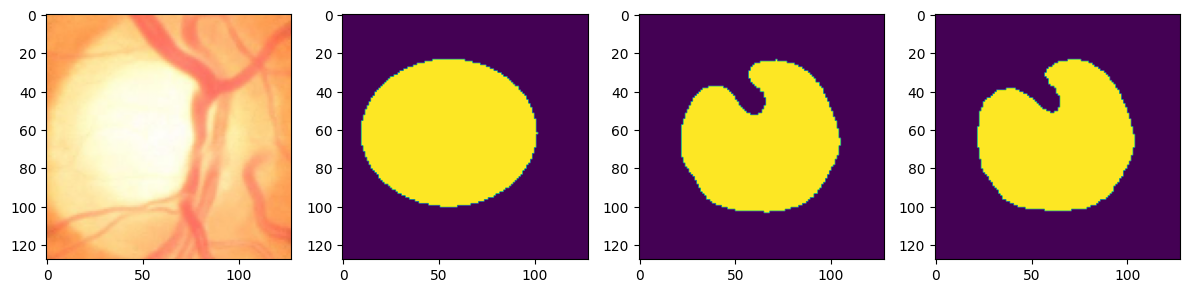

0.837617055190277
0.8333333333333334
0.8422081094284318
0.8422081094284318
0.8423212192262602
0.8423212192262602
0.8423212192262602
0.8423212192262602
0.8426604160562555
0.8426604160562555
0.84296875
0.8427427231881227
0.8428557476316046
0.8427734375
0.8426604160562555
0.8428864368713993
0.8428864368713993
0.8428041398164421
0.8428041398164421
0.8429171141267207
0.8429994141769186
0.8429994141769186
0.8429994141769186
0.8429994141769186
0.8429994141769186
0.8429994141769186
0.8429994141769186
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8428864368713993
0.8429994141769186
0.8429994141769186
0.8429994141769186
0.8429994141769186
0.8429994141769186
0.8429994141769186
0.8429994141769186
0.8429171141267207
0.8428041398164421
0.8428041398164421
0.8428864368713993
0.842886

In [18]:
snake_img = snakes(pred_oc)

# Plot results
fig, ax = plt.subplots(1, 4, figsize=(12, 5))
ax[0].imshow(image)
ax[1].imshow(mask_oc)
ax[2].imshow(pred_oc)
ax[3].imshow(snake_img)
plt.tight_layout()
plt.show()


def on_trackbar(a, b, c):
    a = a / 10
    b = b / 10
    c = c / 10

    snake_mask = snakes(pred_oc, a, b, c)

    m = get_metrics(mask_oc, snake_mask, [[1, 2]])
    print(m['dice_OD'])

    # Display the original and smoothed masks side by side
    side_by_side = np.hstack((mask_oc * 255, pred_oc * 255, snake_mask * 255))
    cv.imshow('Snake', side_by_side)


def on_trackbar1(a):
    global initial_alpha
    initial_alpha = a
    on_trackbar(initial_alpha, initial_beta, initial_gamma)


def on_trackbar2(b):
    global initial_beta
    initial_beta = b
    on_trackbar(initial_alpha, initial_beta, initial_gamma)


def on_trackbar3(c):
    global initial_gamma
    initial_gamma = c
    on_trackbar(initial_alpha, initial_beta, initial_gamma)


initial_alpha = 0.1
initial_beta = 2.0
initial_gamma = 5.0

cv.namedWindow('Snake')
cv.createTrackbar('alpha', 'Snake', 1, 50, on_trackbar1)
cv.createTrackbar('beta', 'Snake', 20, 50, on_trackbar2)
cv.createTrackbar('gamma', 'Snake', 50, 100, on_trackbar3)
on_trackbar(initial_alpha, initial_beta, initial_gamma)

cv.waitKey(0)
cv.destroyAllWindows()

## Contour detection method

In [ ]:
from skimage import segmentation
from scipy.ndimage import distance_transform_edt

images, masks = next(iter(val_loader))
images = images.float().to(DEVICE)
masks = masks.long().to(DEVICE)

image = images[0].cpu().numpy().transpose(1, 2, 0) / 255.0
mask = masks[0].cpu().numpy()
prediction = np.zeros_like(mask)
prediction[16:112, 16:112] = 1
prediction[32:96, 32:96] = 2

boundaries = segmentation.find_boundaries(mask, mode='inner').astype(np.uint8)
marked = image.copy()
marked[boundaries == 1] = [0, 0, 0]
dist_map = distance_transform_edt(1 - boundaries)
dist_map = dist_map / dist_map.max()

_, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0, 0].imshow(mask)
ax[0, 1].imshow(boundaries)
ax[0, 2].imshow(dist_map)
ax[0, 3].imshow(dist_map.max() - dist_map)
ax[1, 0].imshow(prediction)
ax[1, 1].imshow(marked)
plt.show()

In [ ]:
model = Unet(in_channels=3, out_channels=1).to(DEVICE)
loss = DiceLoss(num_classes=1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(5):
    acc_loss = 0
    for images, masks in val_loader:

        edge_masks = np.zeros((masks.shape[0], masks.shape[1], masks.shape[2]))
        for b in range(masks.shape[0]):
            mask = masks[b].cpu().numpy()
            boundaries = segmentation.find_boundaries(mask, mode='thick').astype(np.uint8)
            edge_masks[b] = boundaries
        masks = torch.from_numpy(edge_masks)

        images = images.float().to(DEVICE)
        masks = masks.long().to(DEVICE)

        outputs = model(images)
        loss_value = loss(outputs, masks)
        acc_loss += loss_value.item()

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

    # plot example
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    # probs = F.softmax(outputs, dim=1)
    # preds = torch.argmax(probs, dim=1).cpu().numpy()
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float().cpu().numpy().transpose(0, 2, 3, 1)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(images[0].transpose(1, 2, 0) / 255.0)
    ax[1].imshow(masks[0])
    ax[2].imshow(preds[0])
    plt.show()

    print(f'Epoch {epoch + 1} loss:', acc_loss / len(val_loader))
